In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Bibliotecas

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score

In [ ]:
!python -m spacy download pt
import spacy
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

     |████████████████████████████████| 21.2 MB 1.1 MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-py3-none-any.whl size=21186281 sha256=aa6b43e8509120a1e27d845adacb32cd36e2525b988ddccb55a64153d0cc0c18
  Stored in directory: /tmp/pip-ephem-wheel-cache-lyjmkhfa/wheels/c3/f9/0c/5c014a36941a00f5df5fc0756cb961d7c457a978e697a6ce3b
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

#### Importação dos Dados

In [ ]:
path = '/content/drive/MyDrive/Desafios Mandacaru.dev/Texto/train.txt'
#/content/drive/MyDrive/Desafios Mandacaru/Desafio 02/train.txt
df = pd.read_table(path, header=None, names=['text', 'target'] )

In [ ]:
df.head()

,text,target
0,re enl dailyupdate txt you have been subscribe...,NORMAL
1,request for assistance strictly confidential i...,FRAUD
2,this is an official legal notice for an unclai...,FRAUD
3,re enron credit model docs for the comparative...,NORMAL
4,fw energy leader consulting generation evaluat...,NORMAL


In [ ]:
print(f'Número de registros: {df.shape[0]}')

Número de registros: 2400


In [ ]:
df['target'].value_counts()

NORMAL    800
FRAUD     800
SPAM      800
Name: target, dtype: int64

### Pré-processamento

- StopWords
- Stemming
- Lemmatization

In [ ]:
# Stop words na lingua inglesa
print(nltk.corpus.stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# Exemplo de Stemming
nltk.download('rslp')
stemmer = nltk.stem.RSLPStemmer()
df_palavras = pd.DataFrame(['amigos', 'amigas', 'amizade', 'carreira', 'carreiras'], columns=['Original'])
display(df_palavras)
df_palavras['nltk_stemmer'] = [stemmer.stem(palavra) for palavra in df_palavras['Original']]
display(df_palavras)

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


,Original
0,amigos
1,amigas
2,amizade
3,carreira
4,carreiras


,Original,nltk_stemmer
0,amigos,amig
1,amigas,amig
2,amizade,amizad
3,carreira,carr
4,carreiras,carr


In [ ]:
# Exemplo de Lemmatization
nlp = spacy.load('pt')
doc = nlp(str([palavra for palavra in df_palavras['Original']]))
df_palavras['spacy_lemma'] = [token.lemma_ for token in doc if token.pos_ == 'NOUN']
df_palavras

,Original,nltk_stemmer,spacy_lemma
0,amigos,amig,amigo
1,amigas,amig,amigo
2,amizade,amizad,amizade
3,carreira,carr,carreira
4,carreiras,carr,carreira


In [ ]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
stopwords_ = nltk.corpus.stopwords.words("english")

In [ ]:
df['text_clean'] = df['text'].apply(lambda x: preprocess_text(x, True, True, stopwords_))

In [ ]:
# contar a quantidade de palavras distintas 
def count_words(text):
  conjunto_words = set()
  for doc in text.str.split():
     for d in doc:
       conjunto_words.add(d)
  return len(conjunto_words)

#### Antes e depois do pré-processamento

In [ ]:
df['text'][100]

'save number on ce credits no hidden fees over number number credits over number courses number internet based high quality courses unlimited access complete this form for a free guest demo name e mail phone city state we don t want anybody to receive our mailing who does not wish to receive them to be removed from this mailing list do not reply to this message instead go here http www insuranceiq com optout legal notice'

In [ ]:
df['text_clean'][100]

'save number ce credit hidden fee number number credit number cours number internet base high qualiti cours unlimit access complet form free guest demo name e mail phone citi state want anybodi receiv mail wish receiv remov mail list repli messag instead go http www insuranceiq com optout legal notic'

In [ ]:
df['text_len'] = df['text'].apply(lambda doc: len(doc))
df['text_len_clean'] = df['text_clean'].apply(lambda doc: len(doc))

In [ ]:
count_words(df['text'])

26251

In [ ]:
count_words(df['text_clean'])

20311

#### Codificação das Labels

In [ ]:
le = LabelEncoder()
df['target']  = le.fit_transform(df['target'])

#### Mapeamento

In [ ]:
print(*list(enumerate(le.classes_)), sep='\n')

(0, 'FRAUD')
(1, 'NORMAL')
(2, 'SPAM')


In [ ]:
df[['text_clean', 'target']].head()

,text_clean,target
0,enl dailyupd txt subscrib enl dailyupd txt ema...,1
1,request assist strictli confidenti mr gandu ay...,0
2,offici legal notic unclaim fund left engr ga j...,0
3,enron credit model doc compar model studi sent...,1
4,fw energi leader consult gener evalu ege vinc ...,1


#### Divisão em variável target e variável preditora

In [ ]:
X = df['text_clean'].values
y = df['target'].values

### Vetorização

A vetorização de textos consiste na representação de um texto na forma de um vetor de termos. Esta é a etapa em que as palavras são convertidas em números e assim podem ser processados pelos algoritmos

**TF** = (Número de repetições de palavra em um documento) / (Nº de palavras em um documento)\
**IDF** = Log[(Número de documentos) / (Número de documentos contendo a palavra)] \
**TF-IDF** = TFxIDF

* Document 1 **It is going to rain today.**
* Document 2 **Today I am not going outside.**
* Document 3 **I am going to watch the season premiere.**

### Tokenização

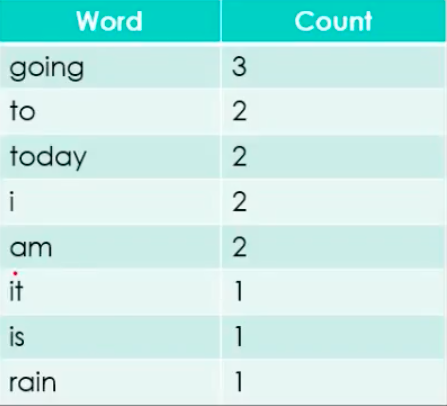

### TF

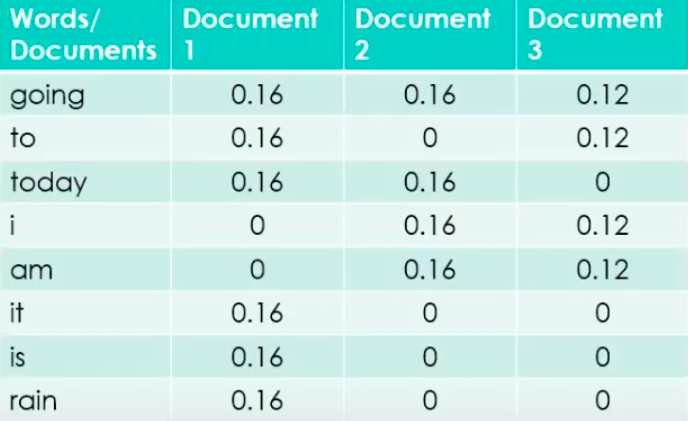

### IDF

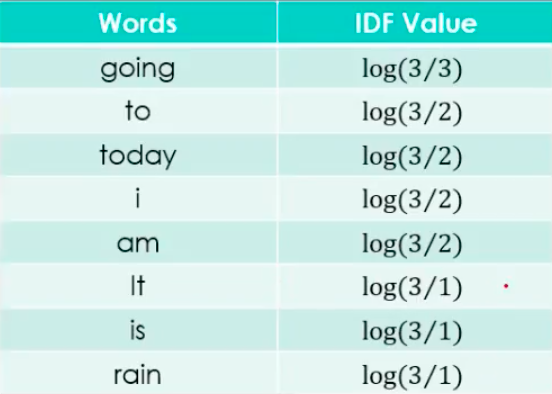

### TF-IDF

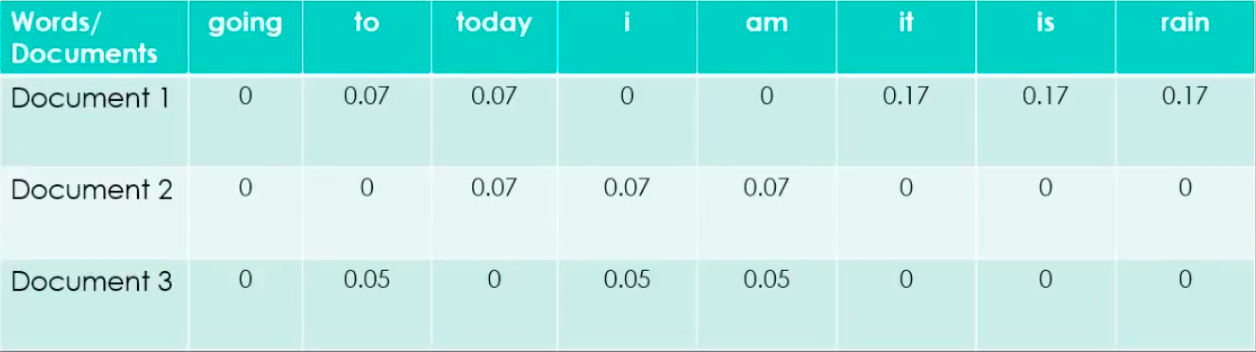

In [ ]:
tf = TfidfVectorizer()
X_tfidf = tf.fit_transform(X)

In [ ]:
tf.vocabulary_

{'enl': 6071,
 'dailyupd': 4344,
 'txt': 18556,
 'subscrib': 17277,
 'email': 5881,
 'address': 271,
 'vkamin': 19304,
 'enron': 6091,
 'com': 3467,
 'unsubscrib': 18854,
 'send': 16130,
 'blank': 2078,
 'request': 15283,
 'assist': 1259,
 'strictli': 17203,
 'confidenti': 3708,
 'mr': 12034,
 'gandu': 7536,
 'ayuba': 1504,
 'account': 157,
 'nigerian': 12609,
 'nation': 12356,
 'petroleum': 13793,
 'corpor': 3959,
 'nnpc': 12658,
 'head': 8277,
 'sevenman': 16219,
 'tender': 17767,
 'board': 2133,
 'charg': 2996,
 'contract': 3861,
 'award': 1476,
 'payment': 13637,
 'approv': 1056,
 'came': 2632,
 'know': 10176,
 'search': 16021,
 'reliabl': 15159,
 'reput': 15274,
 'person': 13757,
 'handl': 8163,
 'transact': 18284,
 'involv': 9444,
 'transfer': 18321,
 'huge': 8715,
 'sum': 17356,
 'money': 11890,
 'foreign': 7166,
 'seri': 16176,
 'execut': 6500,
 'consortium': 3803,
 'multin': 12208,
 'oil': 13017,
 'industri': 9132,
 'favour': 6775,
 'origin': 13223,
 'valu': 19076,
 'deliber':

In [ ]:
X_tfidf.shape

(2400, 20287)

#### Divisão dos Dados

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train_v2, X_test, y_train_v2, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

#### Rede Neural

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint

In [ ]:
path = '/content/drive/MyDrive/Desafios Mandacaru.dev/Texto/model_v1.weights.best.hdf5'
checkpointer = ModelCheckpoint(filepath=path, 
                               verbose=1,
                              save_best_only=True)

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(20287, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_v2.toarray(), 
                    y_train_v2, 
                    epochs=50, 
                    batch_size=16, 
                    callbacks=[checkpointer],
                    validation_data=(X_valid.toarray(), y_valid))

Epoch 1/50
90/90 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.9160
Epoch 00001: val_loss improved from inf to 0.16758, saving model to /content/drive/MyDrive/Desafios Mandacaru.dev/Texto/model_v1.weights.best.hdf5
90/90 [==============================] - 3s 11ms/step - loss: 0.5787 - accuracy: 0.9160 - val_loss: 0.1676 - val_accuracy: 0.9792
Epoch 2/50
86/90 [===========================>..] - ETA: 0s - loss: 0.1020 - accuracy: 0.9811
Epoch 00002: val_loss improved from 0.16758 to 0.07101, saving model to /content/drive/MyDrive/Desafios Mandacaru.dev/Texto/model_v1.weights.best.hdf5
90/90 [==============================] - 0s 4ms/step - loss: 0.0996 - accuracy: 0.9812 - val_loss: 0.0710 - val_accuracy: 0.9812
Epoch 3/50
87/90 [============================>.] - ETA: 0s - loss: 0.0439 - accuracy: 0.9899
Epoch 00003: val_loss improved from 0.07101 to 0.05911, saving model to /content/drive/MyDrive/Desafios Mandacaru.dev/Texto/model_v1.weights.best.hdf5
90/90 [===

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
def loss_acc_plot(hist, metric, epochs):
  plt.figure(figsize=(12, 7))
  epochs_range = range(1, epochs + 1)
  train_data_vl = hist.history[metric]
  validation_data_vl = hist.history['val_' + metric]
  plt.plot(epochs_range,  train_data_vl, '-o',label='Train Data', c='g')
  plt.plot(epochs_range, validation_data_vl, '-o', label='Validation Data', c='r')
  plt.legend()
  plt.xticks(range(0, epochs + 1, 5))

  plt.xlabel('Epochs', fontsize=12)
  plt.ylabel(metric, fontsize=12)
  plt.title(f'Training {metric}', fontsize=20)

#### Avaliação

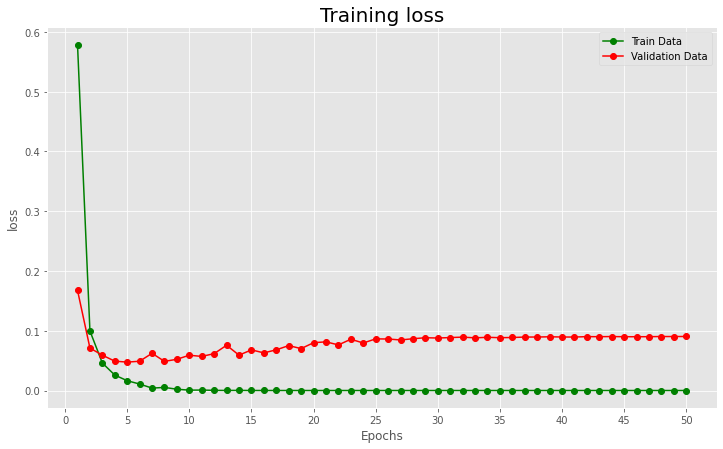

In [ ]:
loss_acc_plot(history, 'loss', epochs=50)

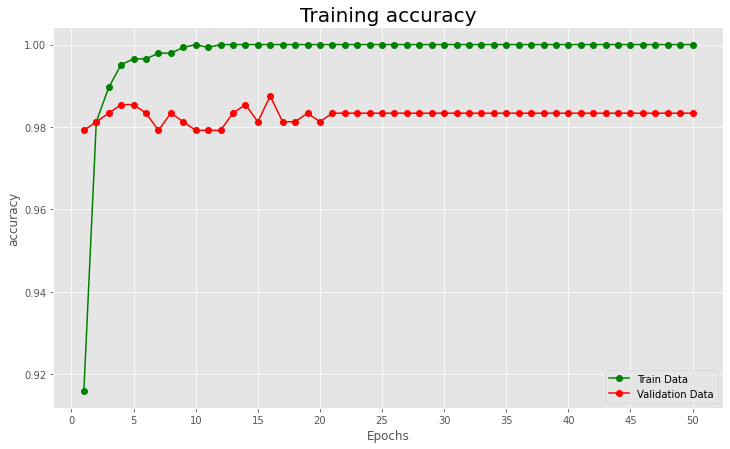

In [ ]:
loss_acc_plot(history, 'accuracy', epochs=50)

In [ ]:
model.load_weights(path)
loss, accuracy = model.evaluate(X_test.toarray(), y_test)

15/15 [==============================] - 0s 3ms/step - loss: 0.0773 - accuracy: 0.9833


In [ ]:
y_pred = model.predict(X_test.toarray())
y_pred = [ np.argmax(y) for y in y_pred]

In [ ]:
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

       FRAUD       0.98      0.98      0.98       160
      NORMAL       1.00      0.99      1.00       160
        SPAM       0.97      0.97      0.97       160

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



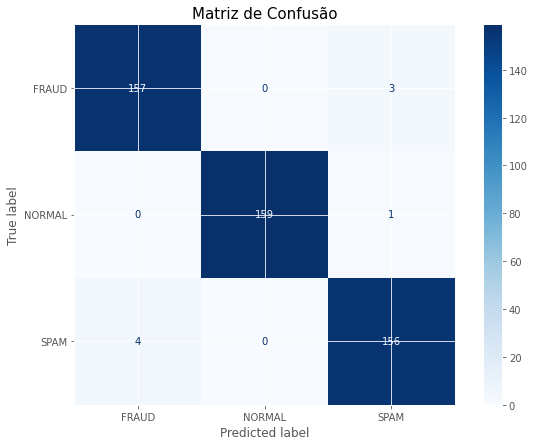

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('Matriz de Confusão', fontsize=15)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_).plot(ax=ax,  cmap=plt.cm.Blues)
plt.show()